Epoch #1


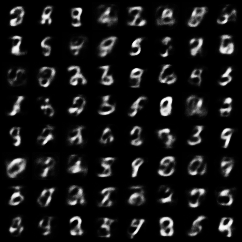



Epoch #2


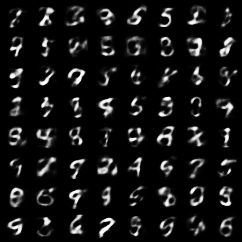



Epoch #3


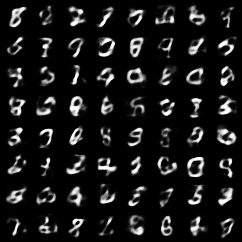



Epoch #4


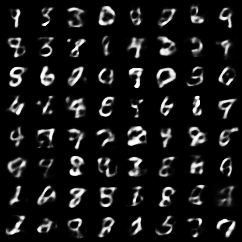



Epoch #5


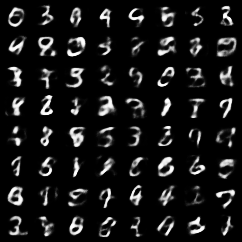



Epoch #6


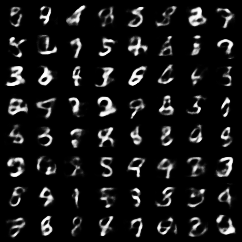



Epoch #7


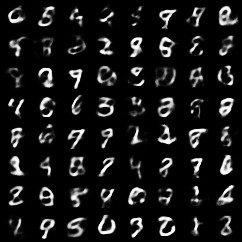



Epoch #8


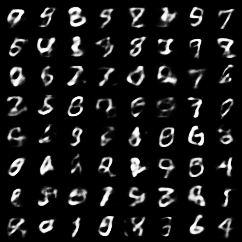



Epoch #9


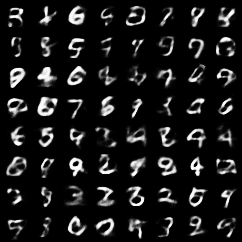



Epoch #10


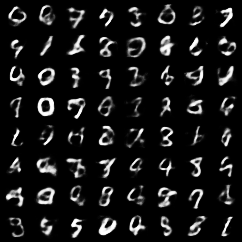



Epoch #11


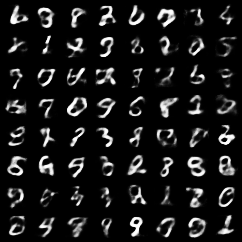



Epoch #12


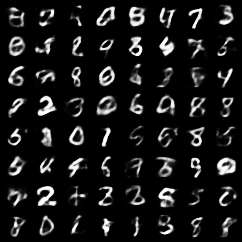



Epoch #13


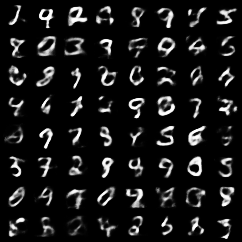



Epoch #14


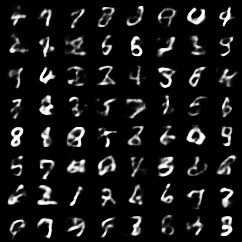



Epoch #15


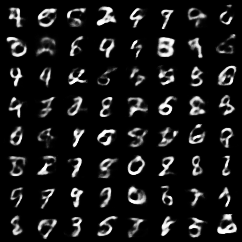



Epoch #16


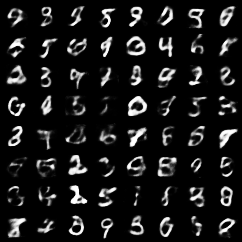



Epoch #17


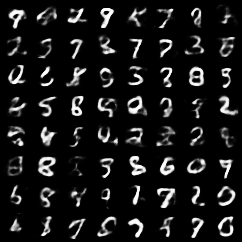



Epoch #18


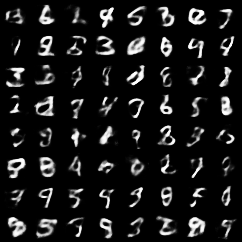



Epoch #19


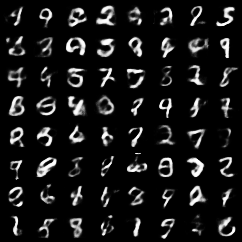



Epoch #20


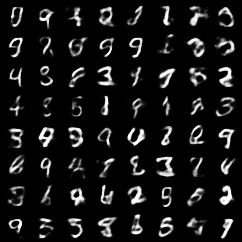



Epoch #21


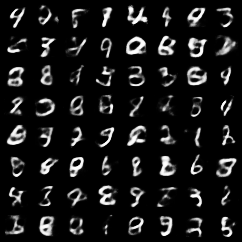



Epoch #22


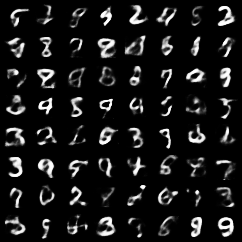



Epoch #23


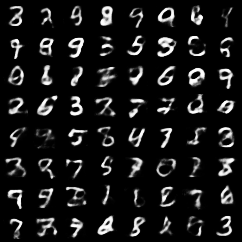



Epoch #24


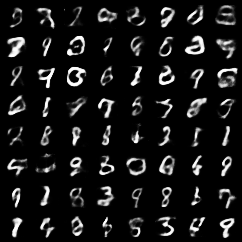



Epoch #25


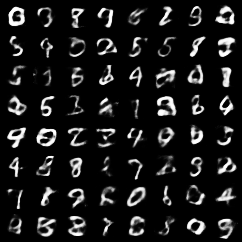



Epoch #26


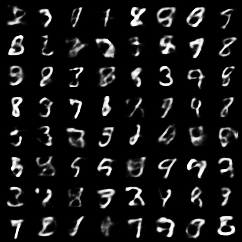



Epoch #27


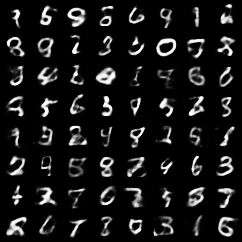



Epoch #28


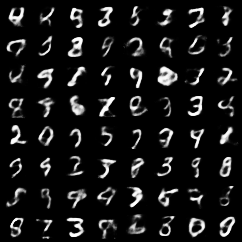



Epoch #29


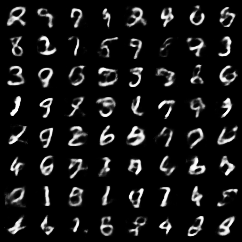



Epoch #30


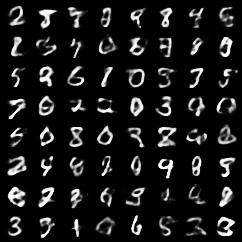



Epoch #31


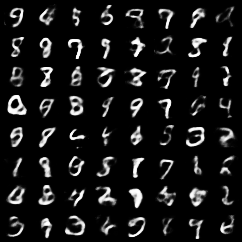



Epoch #32


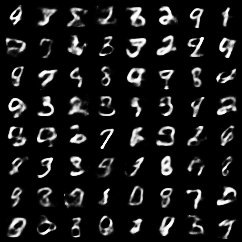



Epoch #33


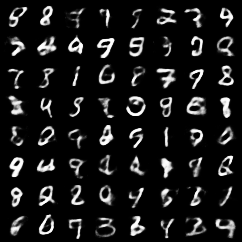



Epoch #34


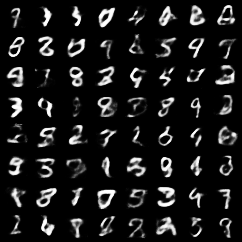



Epoch #35


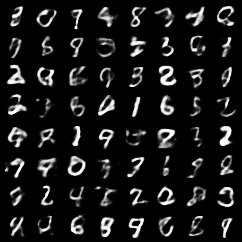



Epoch #36


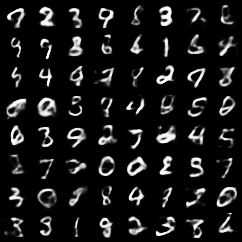



Epoch #37


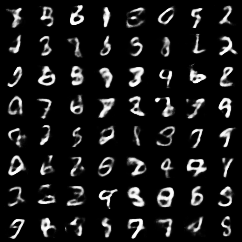



Epoch #38


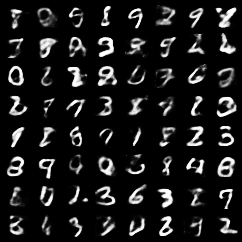



Epoch #39


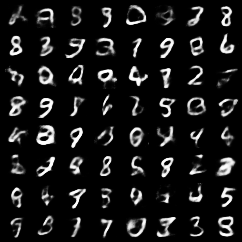



Epoch #40


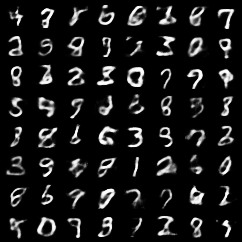



Epoch #41


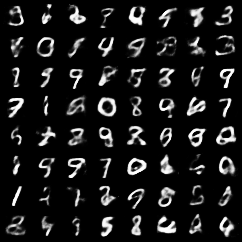



Epoch #42


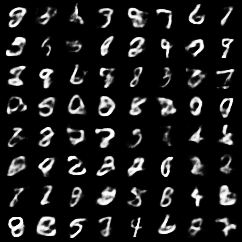



Epoch #43


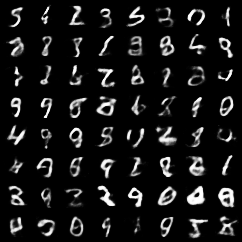



Epoch #44


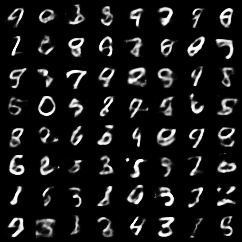



Epoch #45


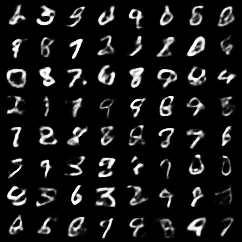



Epoch #46


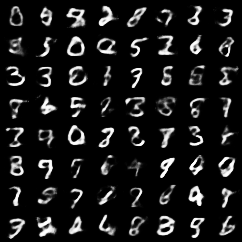



Epoch #47


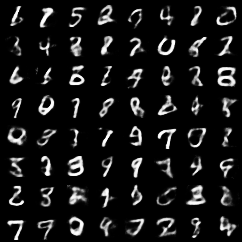



Epoch #48


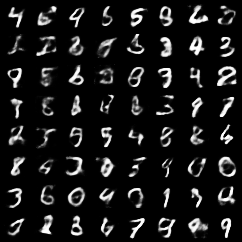



Epoch #49


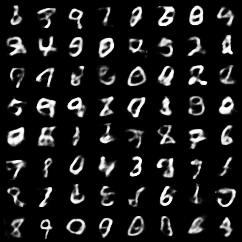



Epoch #50


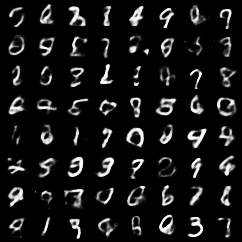

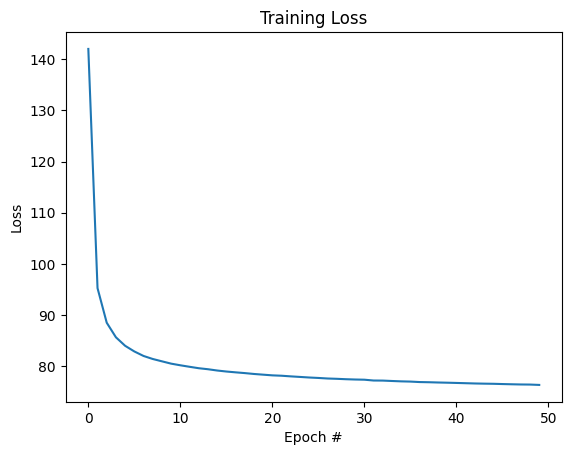

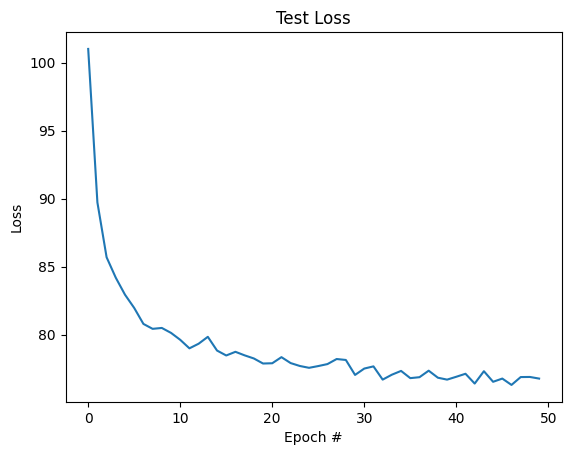

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F

if not os.path.exists('results'):
    os.mkdir('results')

batch_size = 100
latent_size = 20

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #TODO
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        self.fc3 = nn.Linear(latent_size, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, means, log_variances):
        std = torch.exp(0.5 * log_variances)
        eps = torch.randn_like(std)
        return means + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        means, log_variances = self.encode(x.view(-1, 784))
        z = self.reparameterize(means, log_variances)
        return self.decode(z), means, log_variances

def vae_loss_function(reconstructed_x, x, means, log_variances):
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')

    kld = -0.5 * torch.sum(1 + log_variances - means.pow(2) - log_variances.exp())

    loss = reconstruction_loss + kld

    return loss, reconstruction_loss


def train(model, optimizer):
    train_loss = 0
    train_reconstruction_loss = 0

    model.train()
    for _, (x, _) in enumerate(train_loader):
      x = x.to(device)
      optimizer.zero_grad()
      reconstructed_x, means, log_variances = model(x)
      loss, reconstruction_loss = vae_loss_function(reconstructed_x, x, means, log_variances)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
      train_reconstruction_loss += reconstruction_loss.item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_reconstruction_loss = train_reconstruction_loss / len(train_loader.dataset)

    return avg_train_loss, avg_train_reconstruction_loss


def test(model):
    test_loss = 0
    test_reconstruction_loss = 0

    model.eval()
    with torch.no_grad():
      for x, _ in test_loader:
        x = x.to(device)
        reconstructed_batch, means, log_variances = model(x)
        loss, reconstruction_loss = vae_loss_function(reconstructed_batch, x, means, log_variances)
        test_loss += loss.item()
        test_reconstruction_loss += reconstruction_loss.item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    avg_test_reconstruction_loss = test_reconstruction_loss / len(test_loader.dataset)
    return avg_test_loss, avg_test_reconstruction_loss

epochs = 50
avg_train_losses = []
avg_train_reconstruction_losses = []
avg_test_losses = []
avg_test_reconstruction_losses = []

vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    avg_train_loss, avg_train_reconstruction_loss = train(vae_model, vae_optimizer)
    avg_test_loss, avg_test_reconstruction_loss = test(vae_model)

    avg_train_losses.append(avg_train_loss)
    avg_train_reconstruction_losses.append(avg_train_reconstruction_loss)
    avg_test_losses.append(avg_test_loss)
    avg_test_reconstruction_losses.append(avg_test_reconstruction_loss)

    with torch.no_grad():
        sample = torch.randn(64, latent_size).to(device)
        sample = vae_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Epoch #' + str(epoch))
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

plt.plot(avg_train_reconstruction_losses)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.show()

plt.plot(avg_test_reconstruction_losses)
plt.title('Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.show()
